<b>Important:</b> Save charts to <code>../charts/lab2_profiling/</code> in highly descriptive format to avoid overrides.


In [1]:
import sys
sys.path.insert(1, '../../../utils')
from numpy import log, ndarray
from pandas import read_csv, DataFrame, Series
from matplotlib.pyplot import figure, savefig, show, subplots
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from dslabs_functions import plot_multiline_chart, plot_bar_chart, get_variable_types, plot_multibar_chart, define_grid, derive_date_variables, HEIGHT, plot_multi_scatters_chart
from scipy.stats import norm, expon, lognorm
from seaborn import heatmap

# Dimensionality

In [2]:
filename = "../data/raw/Combined_Flights_2022.csv"
file_tag = "flight_cancellations"
data: DataFrame = read_csv(filename, na_values="")

data.shape

(4078318, 61)

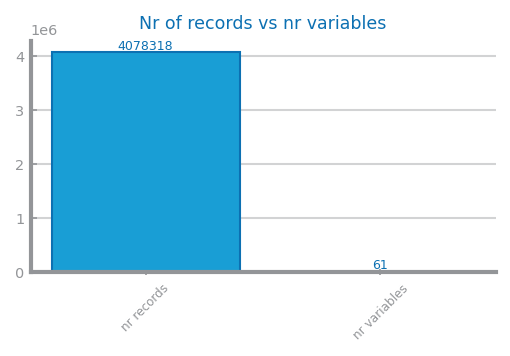

In [20]:
figure(figsize=(4, 2))
values: dict[str, int] = {"nr records": data.shape[0], "nr variables": data.shape[1]}
plot_bar_chart(
    list(values.keys()), list(values.values()), title="Nr of records vs nr variables"
)
savefig(f"../charts/lab2_profiling/{file_tag}_records_variables.png", bbox_inches='tight')
show()

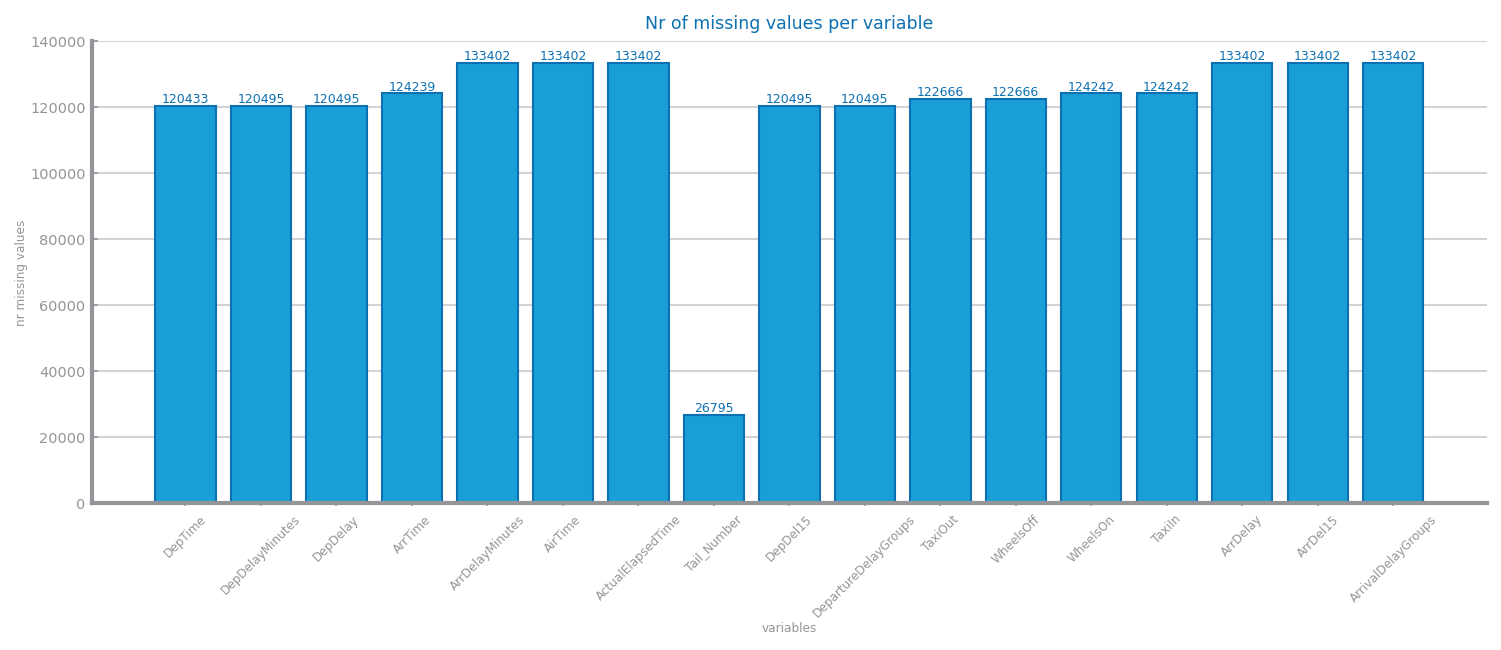

In [4]:
mv: dict[str, int] = {}
for var in data.columns:
    nr: int = data[var].isna().sum()
    if nr > 0:
        mv[var] = nr

figure(figsize=(12, 4))
plot_bar_chart(
    list(mv.keys()),
    list(mv.values()),
    title="Nr of missing values per variable",
    xlabel="variables",
    ylabel="nr missing values",
)
savefig(f"../charts/lab2_profiling/{file_tag}_mv.png", bbox_inches='tight')
show()

In [5]:
data.dtypes

FlightDate             object
Airline                object
Origin                 object
Dest                   object
Cancelled                bool
                       ...   
ArrDel15              float64
ArrivalDelayGroups    float64
ArrTimeBlk             object
DistanceGroup           int64
DivAirportLandings      int64
Length: 61, dtype: object

{'numeric': ['FlightDate', 'CRSDepTime', 'DepTime', 'DepDelayMinutes', 'DepDelay', 'ArrTime', 'ArrDelayMinutes', 'AirTime', 'CRSElapsedTime', 'ActualElapsedTime', 'Distance', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'DOT_ID_Marketing_Airline', 'Flight_Number_Marketing_Airline', 'DOT_ID_Operating_Airline', 'Flight_Number_Operating_Airline', 'OriginAirportID', 'OriginAirportSeqID', 'OriginCityMarketID', 'OriginStateFips', 'OriginWac', 'DestAirportID', 'DestAirportSeqID', 'DestCityMarketID', 'DestStateFips', 'DestWac', 'DepartureDelayGroups', 'TaxiOut', 'WheelsOff', 'WheelsOn', 'TaxiIn', 'CRSArrTime', 'ArrDelay', 'ArrivalDelayGroups', 'DistanceGroup', 'DivAirportLandings'], 'binary': ['Cancelled', 'Diverted', 'DepDel15', 'ArrDel15'], 'date': [], 'symbolic': ['Airline', 'Origin', 'Dest', 'Marketing_Airline_Network', 'Operated_or_Branded_Code_Share_Partners', 'IATA_Code_Marketing_Airline', 'Operating_Airline', 'IATA_Code_Operating_Airline', 'Tail_Number', 'OriginCityName', 'Or

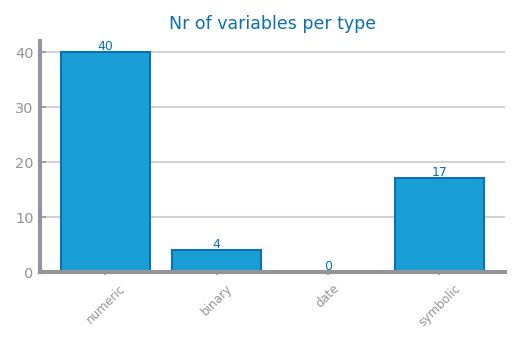

In [21]:
variable_types: dict[str, list] = get_variable_types(data)
print(variable_types)
counts: dict[str, int] = {}
for tp in variable_types.keys():
    counts[tp] = len(variable_types[tp])

figure(figsize=(4, 2))
plot_bar_chart(
    list(counts.keys()), list(counts.values()), title="Nr of variables per type"
)
savefig(f"../charts/lab2_profiling/{file_tag}_variable_types.png", bbox_inches='tight')
show()

In [7]:
symbolic: list[str] = variable_types["symbolic"]
data[symbolic] = data[symbolic].apply(lambda x: x.astype("category"))
data.dtypes

FlightDate            datetime64[ns]
Airline                     category
Origin                      category
Dest                        category
Cancelled                       bool
                           ...      
ArrDel15                     float64
ArrivalDelayGroups           float64
ArrTimeBlk                  category
DistanceGroup                  int64
DivAirportLandings             int64
Length: 61, dtype: object

# Distribution

In [8]:
file_tag = "flight_cancellations"
data: DataFrame = read_csv("../data/raw/Combined_Flights_2022.csv", na_values="")
summary5: DataFrame = data.describe(include="all")
summary5

,FlightDate,Airline,Origin,Dest,Cancelled,Diverted,CRSDepTime,DepTime,DepDelayMinutes,DepDelay,...,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrDelay,ArrDel15,ArrivalDelayGroups,ArrTimeBlk,DistanceGroup,DivAirportLandings
count,4078318,4078318,4078318,4078318,4078318,4078318,4.078318e+06,3.957885e+06,3.957823e+06,3.957823e+06,...,3.955652e+06,3.954076e+06,3.954076e+06,4.078318e+06,3.944916e+06,3.944916e+06,3.944916e+06,4078318,4.078318e+06,4.078318e+06
unique,212,21,375,375,2,2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19,NaN,NaN
top,2022-07-21,Southwest Airlines Co.,ATL,ATL,False,False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1200-1259,NaN,NaN
freq,20844,731925,183697,183671,3955126,4068108,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,256772,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,1.329587e+03,1.334374e+03,1.601494e+01,1.309049e+01,...,1.356576e+03,1.455073e+03,7.894387e+00,1.486058e+03,7.528486e+00,2.164715e-01,-6.256103e-02,NaN,3.663516e+00,3.685098e-03
std,NaN,NaN,NaN,NaN,NaN,NaN,4.904801e+02,5.056219e+02,5.231498e+01,5.332016e+01,...,5.075580e+02,5.378428e+02,6.663118e+00,5.185078e+02,5.524625e+01,4.118393e-01,2.487442e+00,NaN,2.320848e+00,1.141331e-01
min,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00,1.000000e+00,0.000000e+00,-7.800000e+01,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-1.000000e+02,0.000000e+00,-2.000000e+00,NaN,1.000000e+00,0.000000e+00
25%,NaN,NaN,NaN,NaN,NaN,NaN,9.140000e+02,9.170000e+02,0.000000e+00,-5.000000e+00,...,9.320000e+02,1.044000e+03,4.000000e+00,1.103000e+03,-1.400000e+01,0.000000e+00,-1.000000e+00,NaN,2.000000e+00,0.000000e+00
50%,NaN,NaN,NaN,NaN,NaN,NaN,1.320000e+03,1.325000e+03,0.000000e+00,-2.000000e+00,...,1.338000e+03,1.456000e+03,6.000000e+00,1.513000e+03,-5.000000e+00,0.000000e+00,-1.000000e+00,NaN,3.000000e+00,0.000000e+00
75%,NaN,NaN,NaN,NaN,NaN,NaN,1.735000e+03,1.744000e+03,1.100000e+01,1.100000e+01,...,1.758000e+03,1.909000e+03,9.000000e+00,1.920000e+03,1.000000e+01,0.000000e+00,0.000000e+00,NaN,5.000000e+00,0.000000e+00


### Numerical values

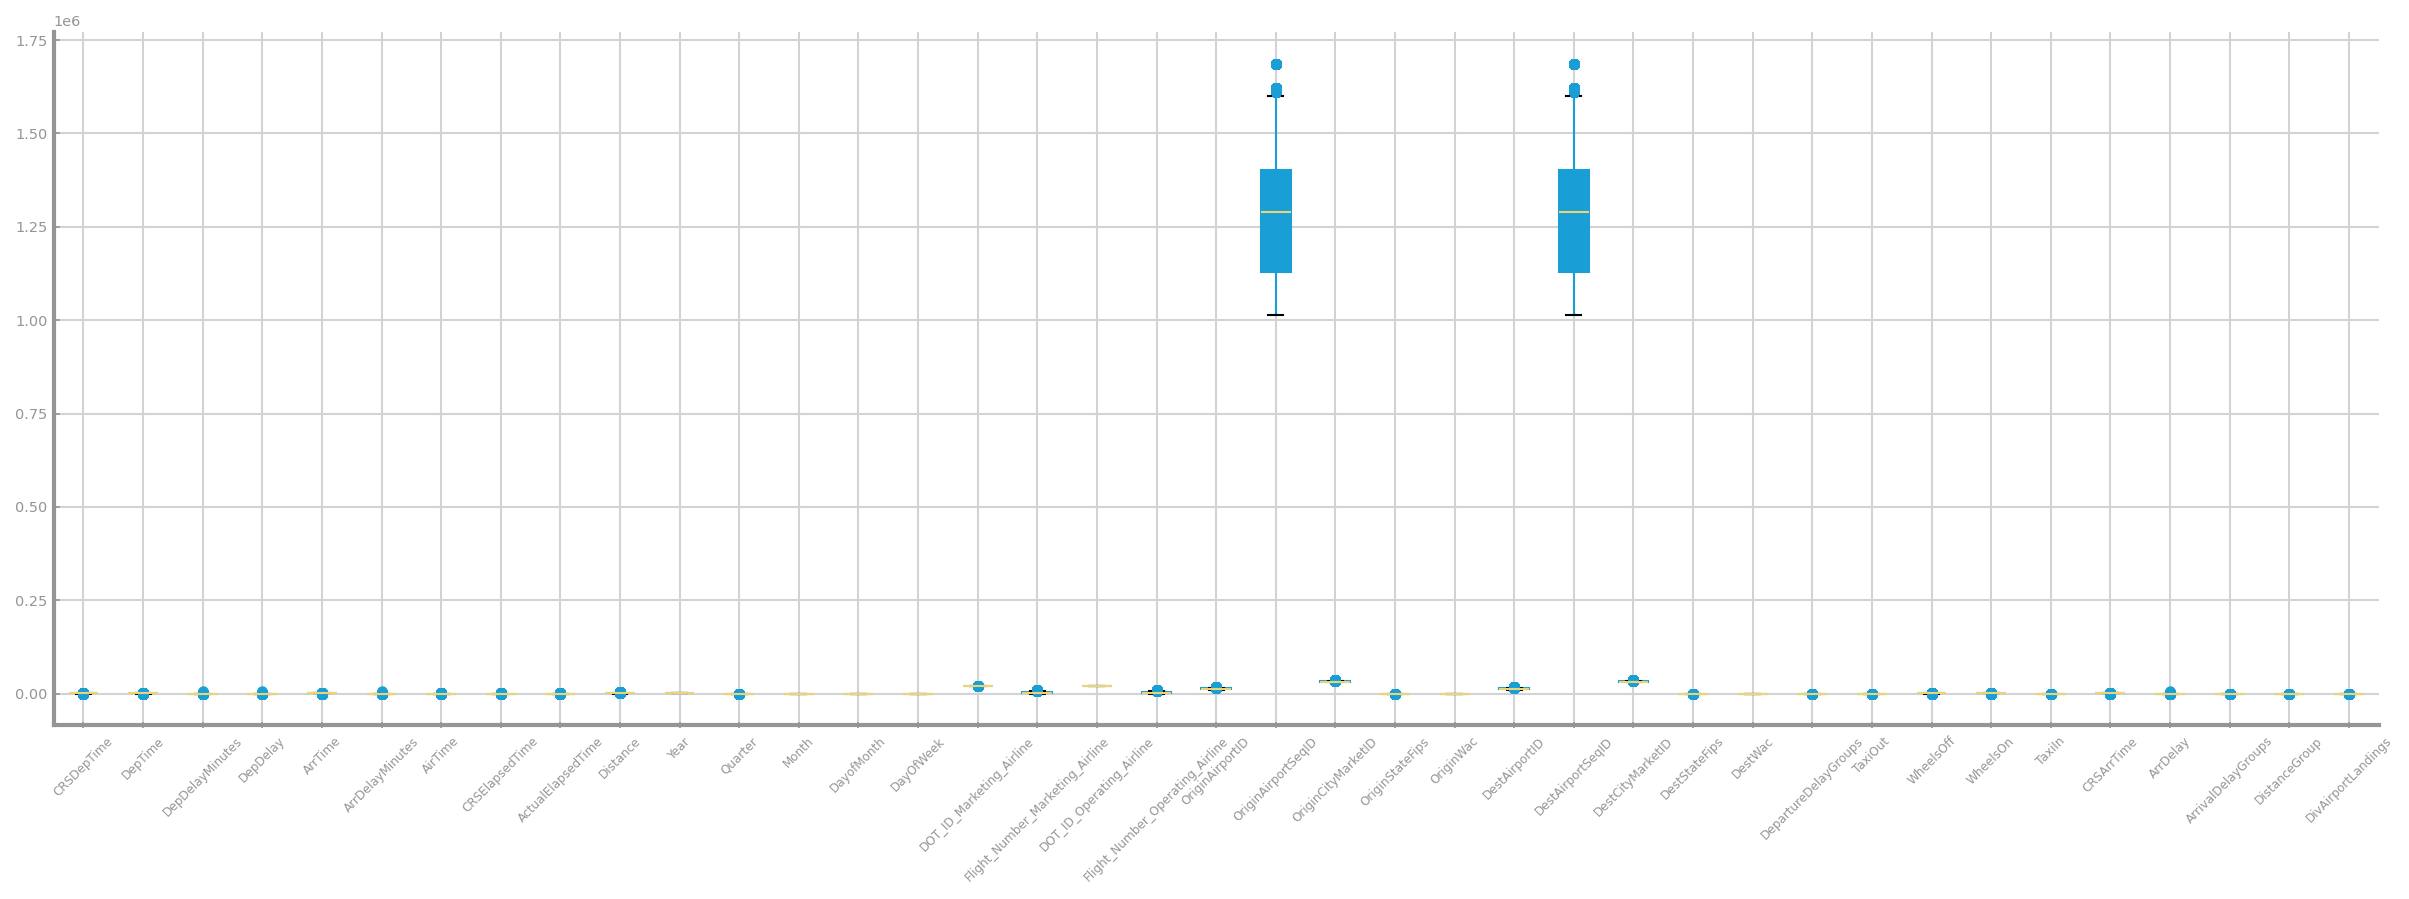

In [9]:
variables_types: dict[str, list] = get_variable_types(data)
numeric: list[str] = variables_types["numeric"]
if [] != numeric:
    data[numeric].boxplot(rot=45, figsize=(20, 6))
    savefig(f"../charts/lab2_profiling/{file_tag}_global_boxplot.png", bbox_inches='tight')
    show()
else:
    print("There are no numeric variables.")

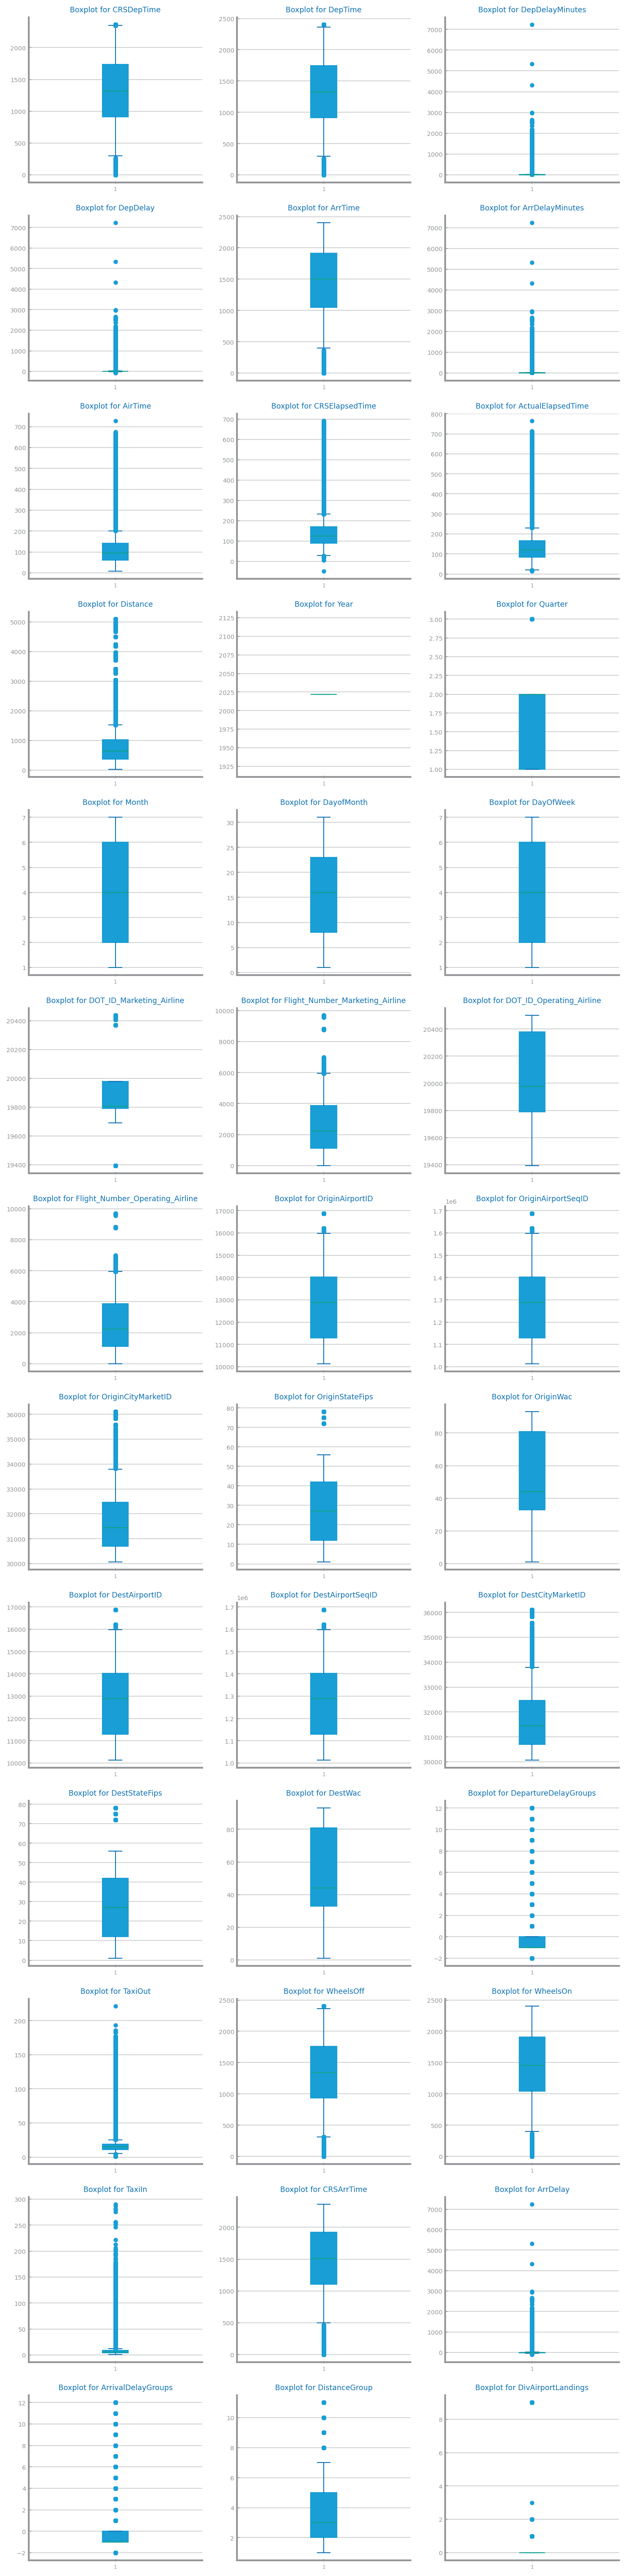

In [10]:
from numpy import ndarray
from matplotlib.figure import Figure
from matplotlib.pyplot import savefig, show, subplots
from dslabs_functions import define_grid, HEIGHT

if [] != numeric:
    rows: int
    cols: int
    rows, cols = define_grid(len(numeric))
    fig: Figure
    axs: ndarray
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    i, j = 0, 0
    for n in range(len(numeric)):
        axs[i, j].set_title("Boxplot for %s" % numeric[n])
        axs[i, j].boxplot(data[numeric[n]].dropna().values)
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    savefig(f"../charts/lab2_profiling/{file_tag}_single_boxplots.png", bbox_inches='tight')
    show()
else:
    print("There are no numeric variables.")

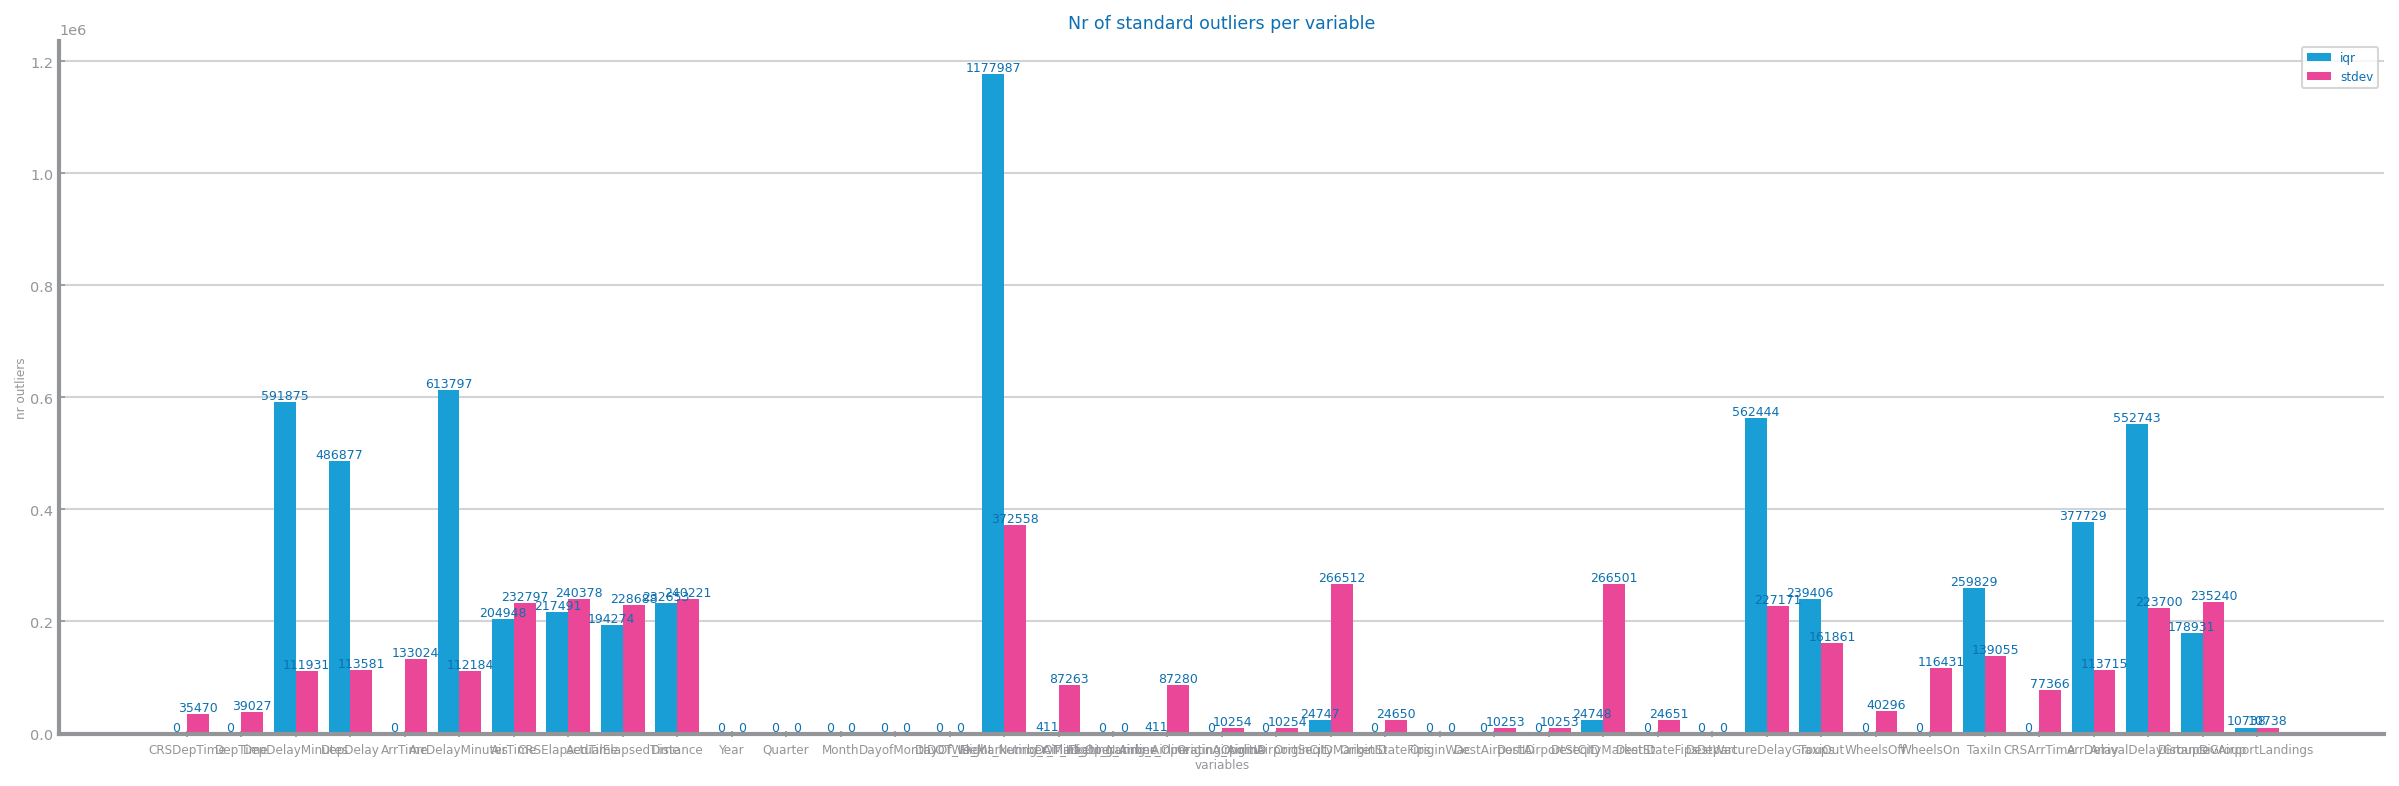

In [11]:
NR_STDEV: int = 2
IQR_FACTOR: float = 1.5


def determine_outlier_thresholds_for_var(
    summary5: Series, std_based: bool = True, threshold: float = NR_STDEV
) -> tuple[float, float]:
    top: float = 0
    bottom: float = 0
    if std_based:
        std: float = threshold * summary5["std"]
        top = summary5["mean"] + std
        bottom = summary5["mean"] - std
    else:
        iqr: float = threshold * (summary5["75%"] - summary5["25%"])
        top = summary5["75%"] + iqr
        bottom = summary5["25%"] - iqr

    return top, bottom


def count_outliers(
    data: DataFrame,
    numeric: list[str],
    nrstdev: int = NR_STDEV,
    iqrfactor: float = IQR_FACTOR,
) -> dict:
    outliers_iqr: list = []
    outliers_stdev: list = []
    summary5: DataFrame = data[numeric].describe()

    for var in numeric:
        top: float
        bottom: float
        top, bottom = determine_outlier_thresholds_for_var(
            summary5[var], std_based=True, threshold=nrstdev
        )
        outliers_stdev += [
            data[data[var] > top].count()[var] + data[data[var] < bottom].count()[var]
        ]

        top, bottom = determine_outlier_thresholds_for_var(
            summary5[var], std_based=False, threshold=iqrfactor
        )
        outliers_iqr += [
            data[data[var] > top].count()[var] + data[data[var] < bottom].count()[var]
        ]

    return {"iqr": outliers_iqr, "stdev": outliers_stdev}


if [] != numeric:
    outliers: dict[str, int] = count_outliers(data, numeric)
    figure(figsize=(20, 6))
    plot_multibar_chart(
        numeric,
        outliers,
        title="Nr of standard outliers per variable",
        xlabel="variables",
        ylabel="nr outliers",
        percentage=False,
    )
    savefig(f"../charts/lab2_profiling/{file_tag}_outliers_standard.png", bbox_inches='tight')
    show()
else:
    print("There are no numeric variables.")

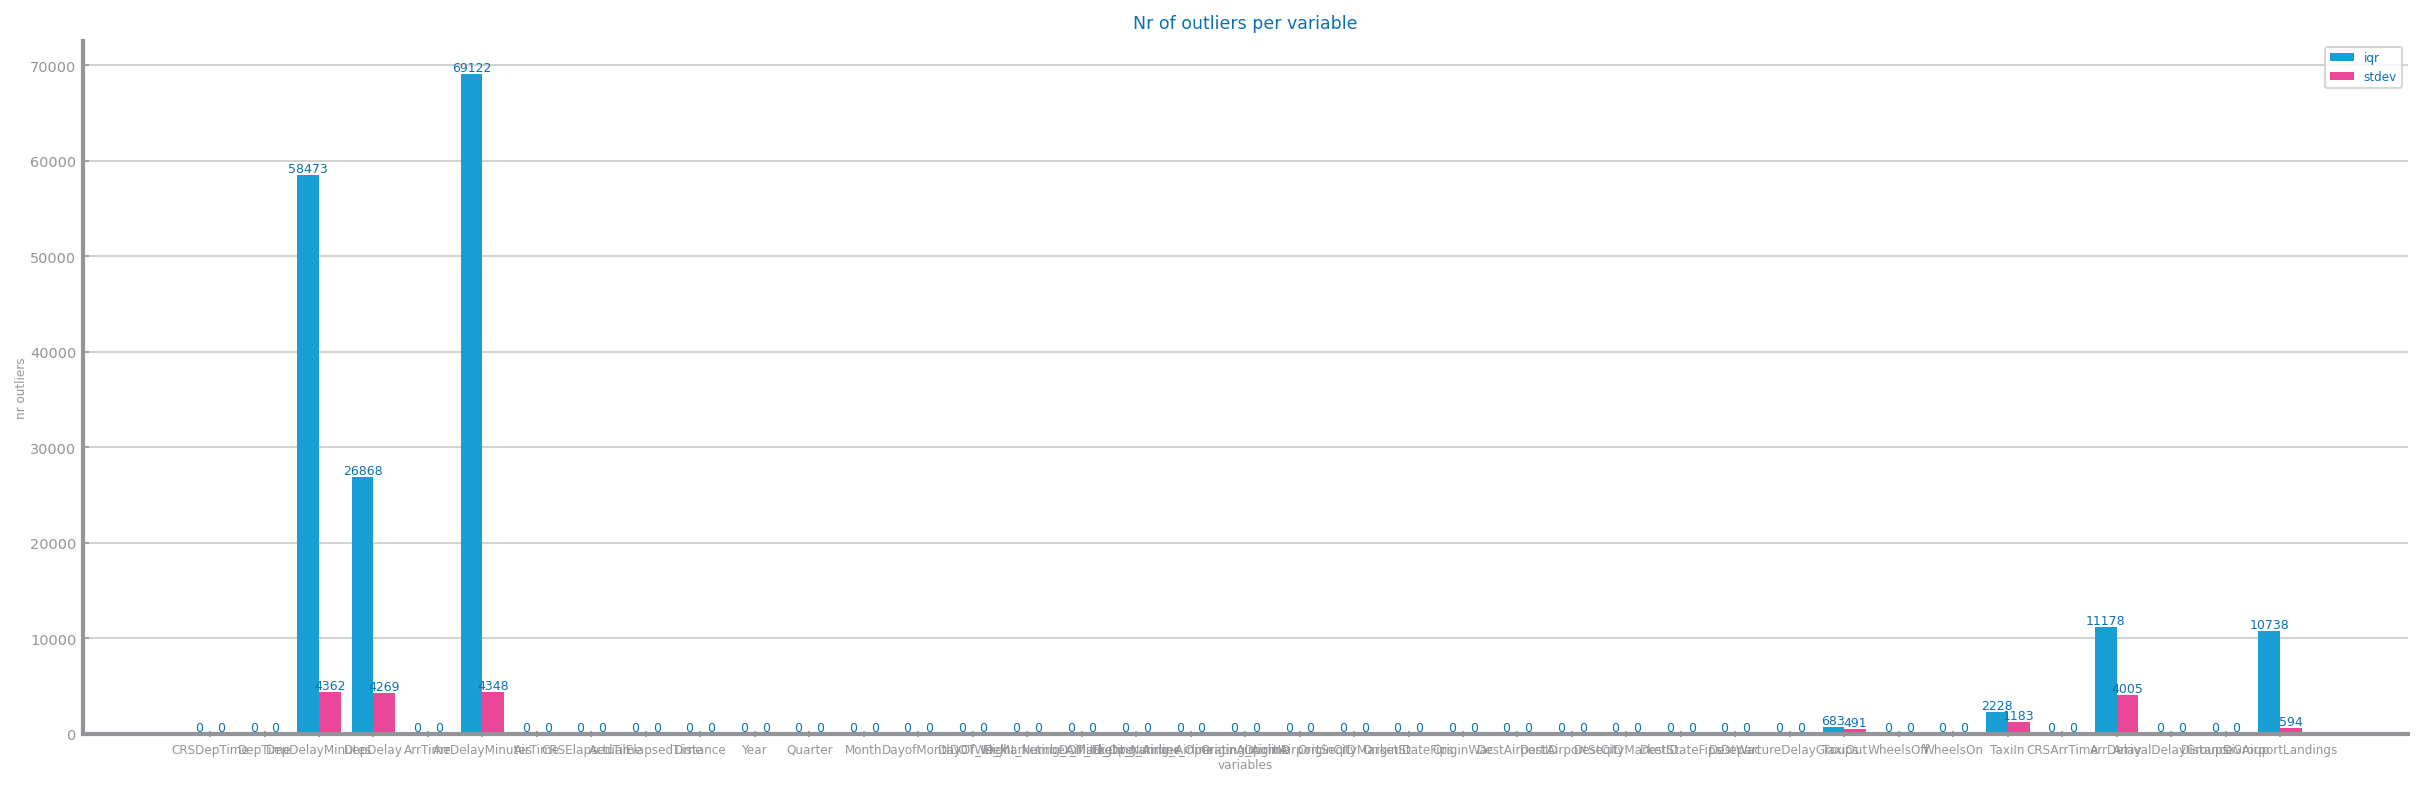

In [12]:
if [] != numeric:
    outliers: dict[str, int] = count_outliers(data, numeric, nrstdev=13, iqrfactor=14.5)
    figure(figsize=(20, 6))
    plot_multibar_chart(
        numeric,
        outliers,
        title="Nr of outliers per variable",
        xlabel="variables",
        ylabel="nr outliers",
        percentage=False,
    )
    savefig(f"../charts/lab2_profiling/{file_tag}_outliers_tuned.png", bbox_inches='tight')
    show()
else:
    print("There are no numeric variables.")

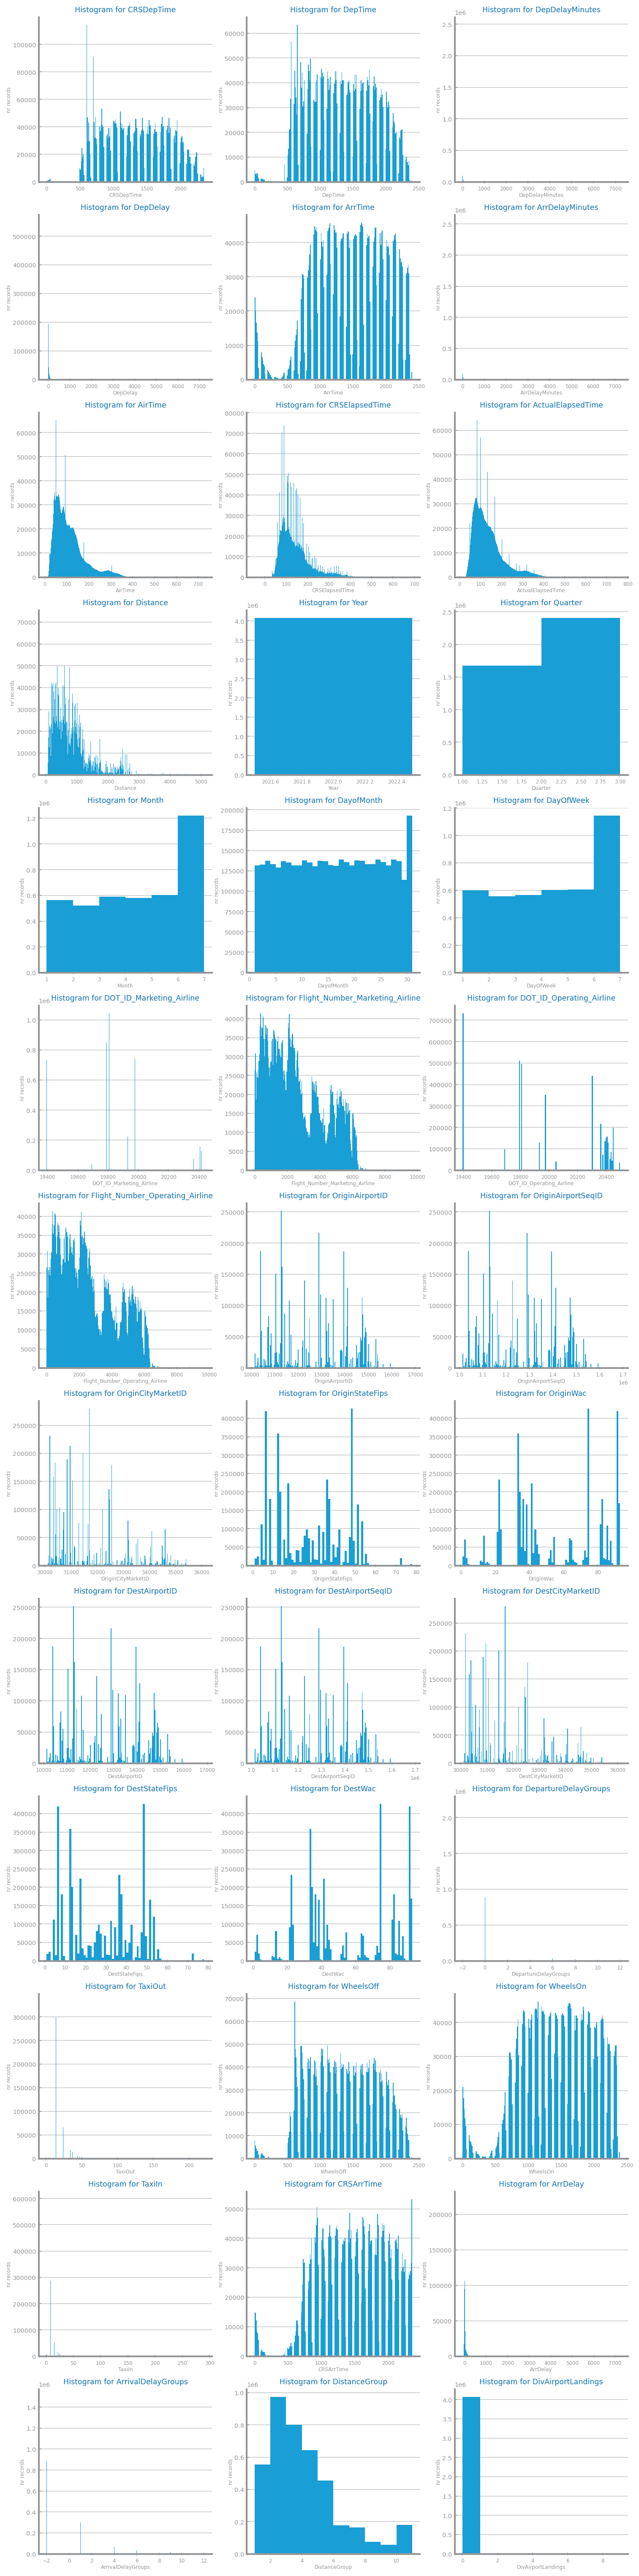

In [13]:
from dslabs_functions import set_chart_labels

if [] != numeric:
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    i: int
    j: int
    i, j = 0, 0
    for n in range(len(numeric)):
        set_chart_labels(
            axs[i, j],
            title=f"Histogram for {numeric[n]}",
            xlabel=numeric[n],
            ylabel="nr records",
        )
        axs[i, j].hist(data[numeric[n]].dropna().values, "auto")
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    savefig(f"../charts/lab2_profiling/{file_tag}_single_histograms_numeric.png", bbox_inches='tight')
    show()
else:
    print("There are no numeric variables.")

In [14]:
def compute_known_distributions(x_values: list) -> dict:
    distributions = dict()
    mean, sigma = norm.fit(x_values)
    distributions["Normal(%.1f,%.2f)" % (mean, sigma)] = norm.pdf(x_values, mean, sigma)
    loc, scale = expon.fit(x_values, floc=0)
    distributions["Exp(%.2f)" % (1 / scale)] = expon.pdf(x_values, loc, scale)
    if min(x_values) > 0:
        sigma, loc, scale = lognorm.fit(x_values, floc=0)
        distributions["LogNor(%.1f,%.2f)" % (log(scale), sigma)] = lognorm.pdf(
            x_values, sigma, loc, scale
        )
    return distributions


def histogram_with_distributions(ax: Axes, series: Series, var: str):
    values: list = series.sort_values().to_list()
    unique_count = len(set(values))
    print(f"{var}: n={len(values)}, unique={unique_count}")

    '''if var == "crash_month":
        print(f"{var}: histogram only (forced)")
        ax.hist(values, 20, density=True)
        ax.set_title("Best fit for %s" % var)
        ax.set_xlabel(var)
        return'''

    if unique_count < 7: # 7 chosen for traffic data, likely should be different for flight data
        print(f"{var}: histogram only")
        ax.hist(values, 20, density=True)
        ax.set_title("Best fit for %s" % var)
        ax.set_xlabel(var)
        return

    print(f"{var}: fitting distributions")
    ax.hist(values, 20, density=True)
    distributions: dict = compute_known_distributions(values)
    plot_multiline_chart(
        values,
        distributions,
        ax=ax,
        title="Best fit for %s" % var,
        xlabel=var,
        ylabel="",
    )


if [] != numeric:
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    i, j = 0, 0
    for n in range(len(numeric)):
        histogram_with_distributions(axs[i, j], data[numeric[n]].dropna(), numeric[n])
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    print("before savefig")
    savefig(f"../charts/lab2_profiling/{file_tag}_histogram_numeric_distribution.png", bbox_inches='tight')
    print("after savefig")

    print("before show")
    show()
    print("after show")
else:
    print("There are no numeric variables.")

CRSDepTime: n=4078318, unique=1320
CRSDepTime: fitting distributions


: 

### Symbolic variables

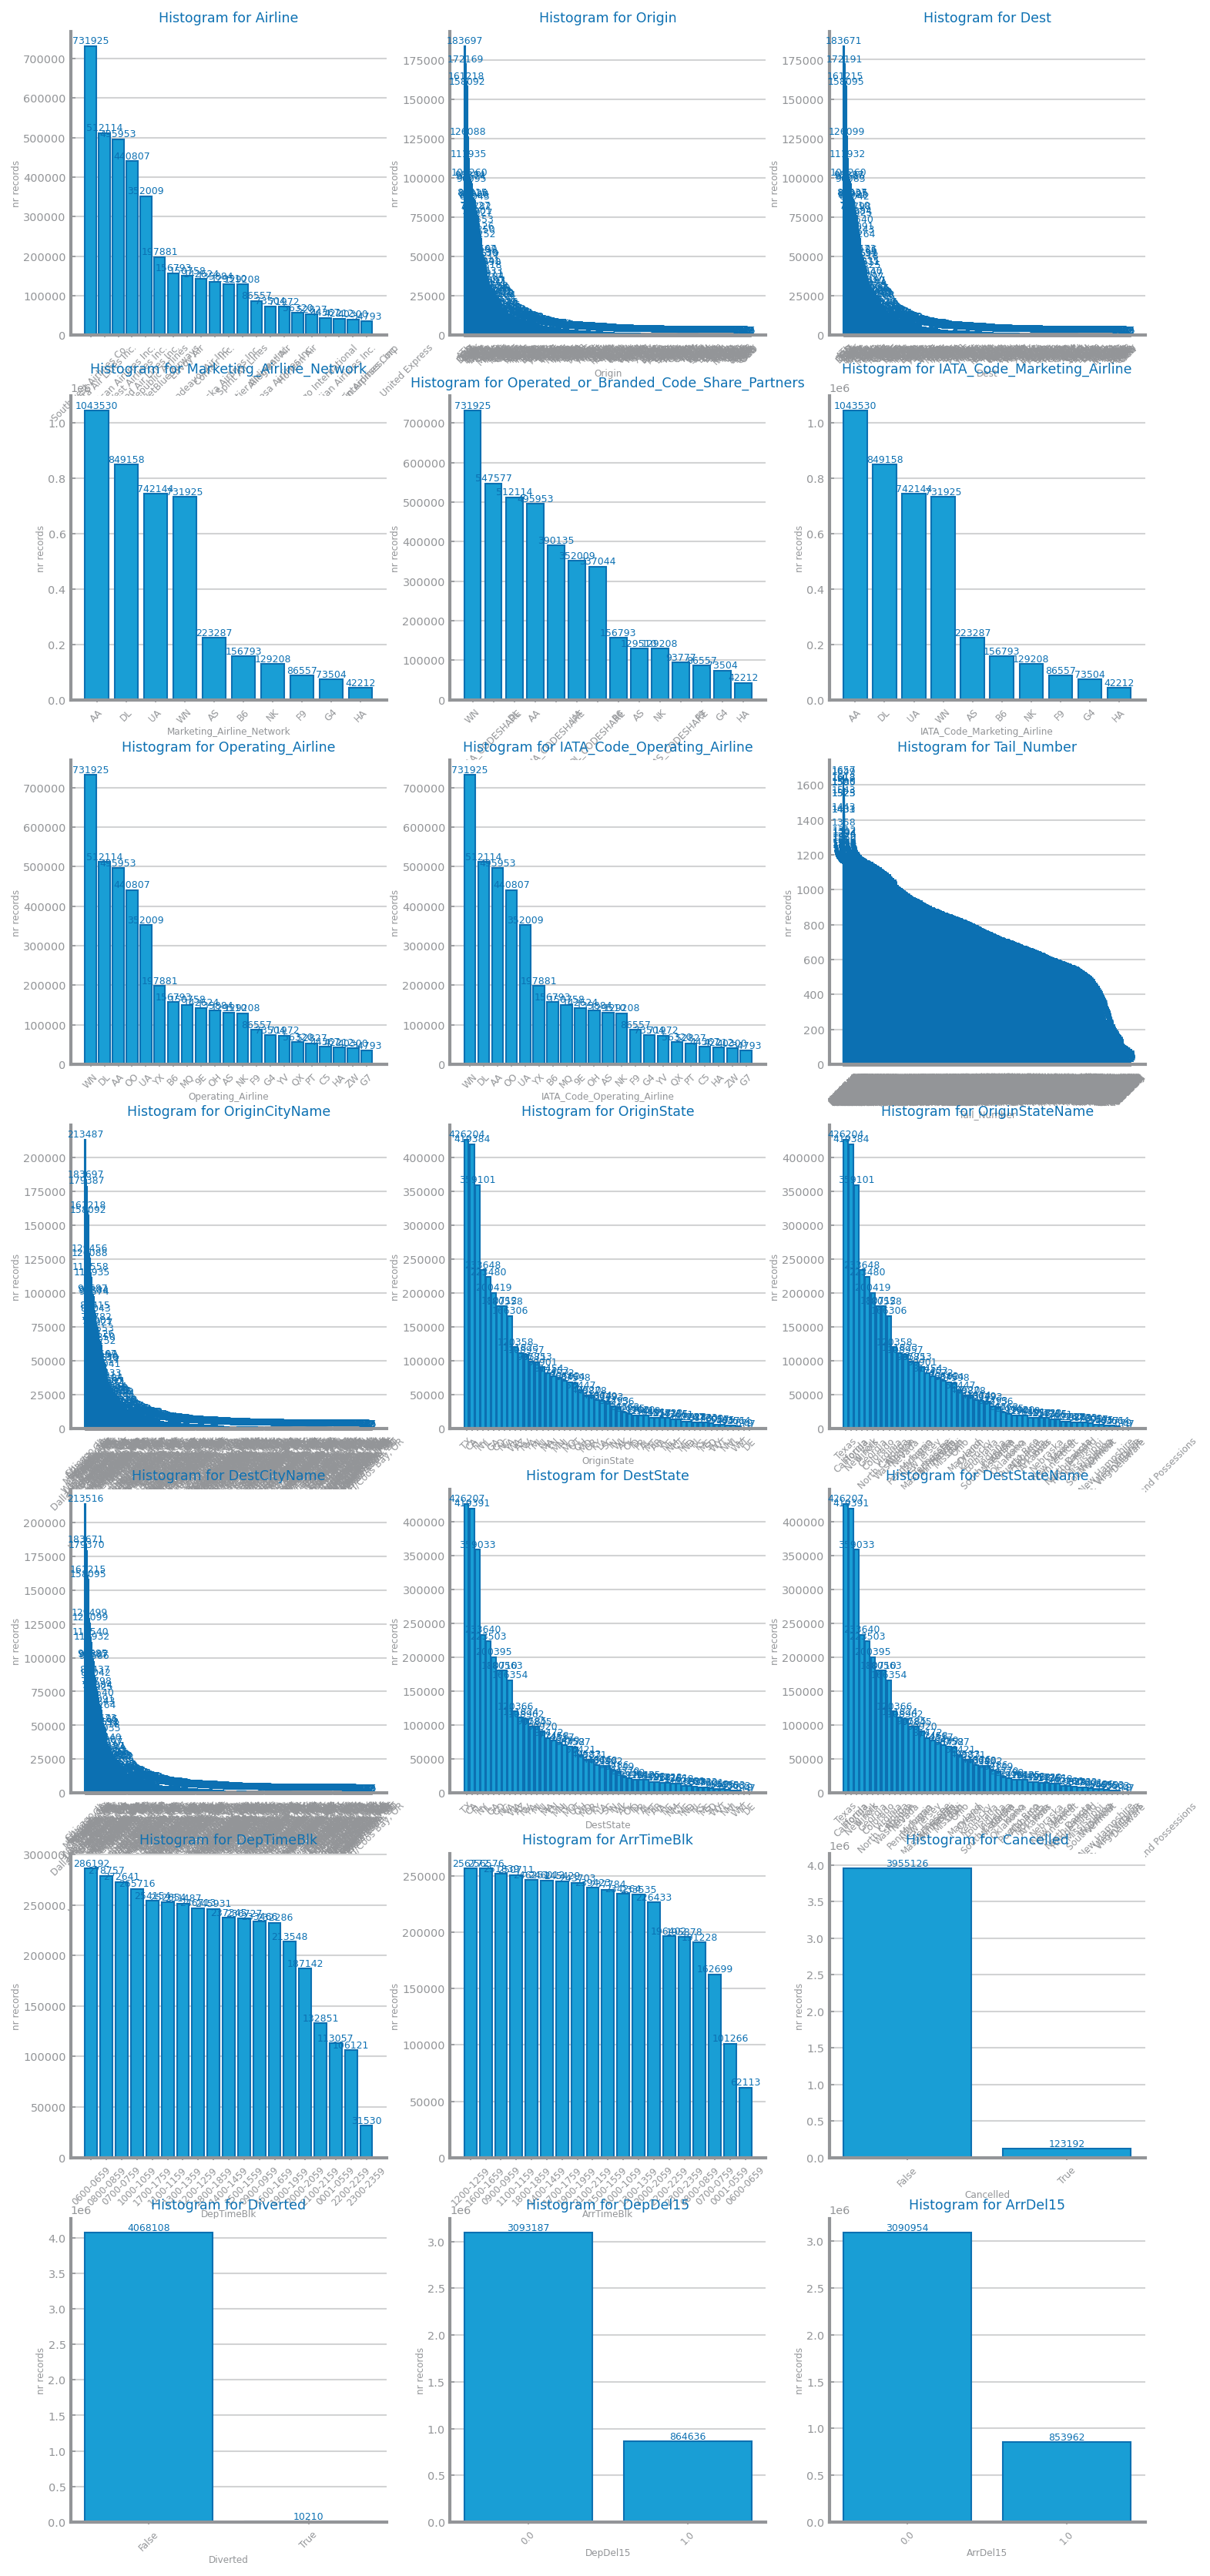

In [31]:
variables_types: dict[str, list] = get_variable_types(data)
symbolic: list[str] = variables_types["symbolic"] + variables_types["binary"]
if [] != symbolic:
    rows, cols = define_grid(len(symbolic))
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    i, j = 0, 0
    for n in range(len(symbolic)):
        counts: Series = data[symbolic[n]].value_counts()
        plot_bar_chart(
            [str(b) for b in counts.index],
            counts.to_list(),
            ax=axs[i, j],
            title="Histogram for %s" % symbolic[n],
            xlabel=symbolic[n],
            ylabel="nr records",
            percentage=False,
        )
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    savefig(f"../charts/lab2_profiling/{file_tag}_histograms_symbolic.png", bbox_inches='tight')
    show()
else:
    print("There are no symbolic variables.")

### Class distribution

In [15]:
data['Cancelled']

0          False
1          False
2          False
3          False
4          False
           ...  
4078313    False
4078314     True
4078315    False
4078316    False
4078317    False
Name: Cancelled, Length: 4078318, dtype: bool

Cancelled
False    3955126
True      123192
Name: count, dtype: int64


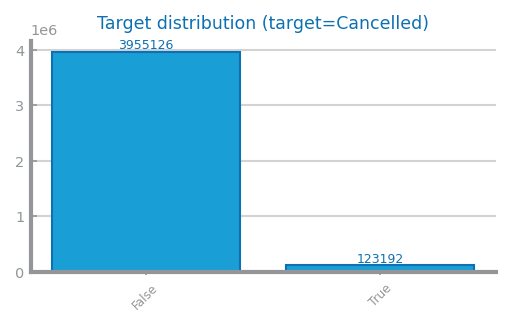

In [30]:
target = "Cancelled"

values: Series = data[target].value_counts()
print(values)

figure(figsize=(4, 2))
plot_bar_chart(
    [str(b) for b in values.index],
    values.to_list(),
    title=f"Target distribution (target={target})",
)
savefig(f"../charts/lab2_profiling/{file_tag}_class_distribution.png", bbox_inches='tight')
show()

# Granularity

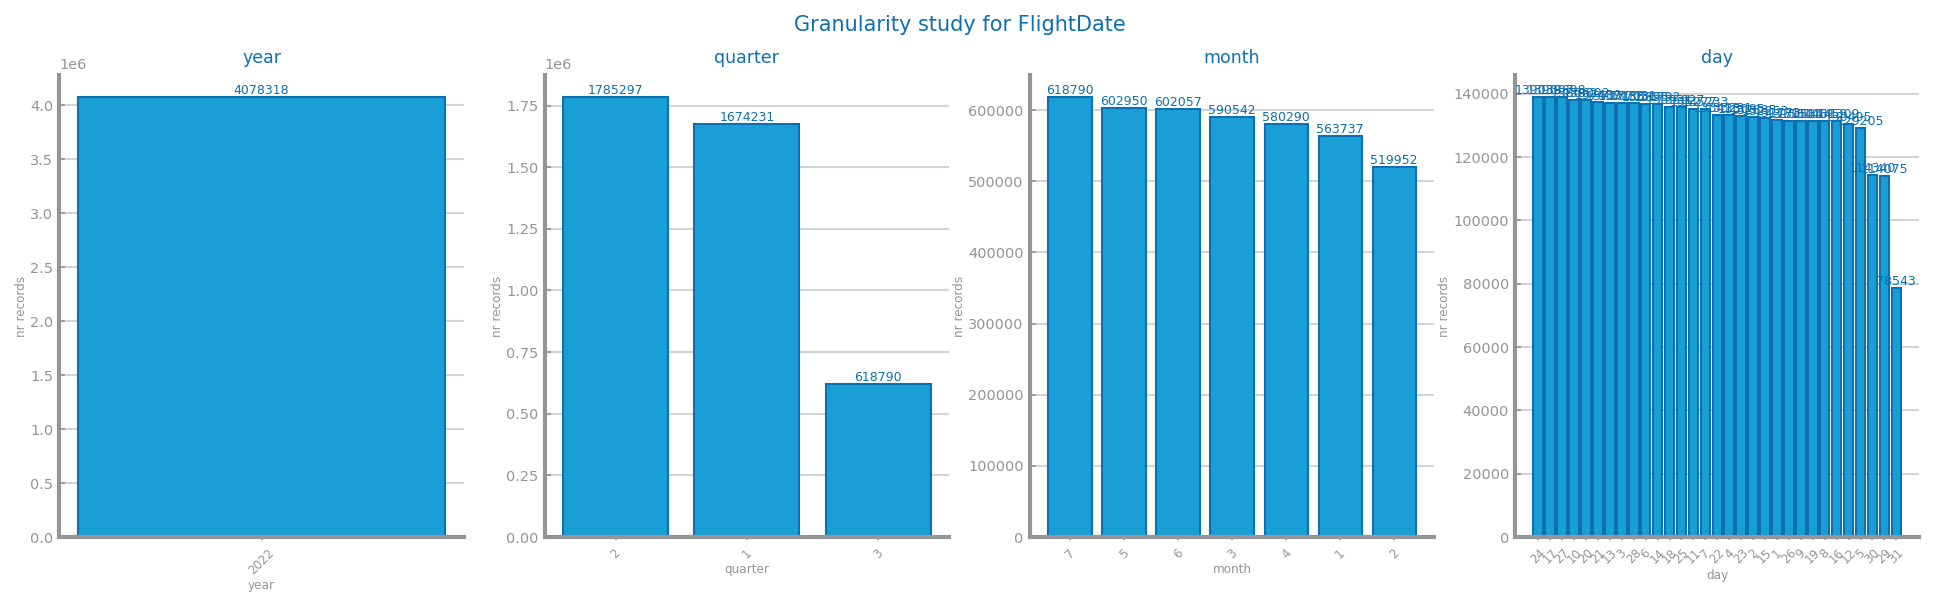

In [32]:
def analyse_date_granularity(data: DataFrame, var: str, levels: list[str]) -> ndarray:
    cols: int = len(levels)
    fig: Figure
    axs: ndarray
    fig, axs = subplots(1, cols, figsize=(cols * HEIGHT, HEIGHT), squeeze=False)
    fig.suptitle(f"Granularity study for {var}")

    for i in range(cols):
        counts: Series[int] = data[var + "_" + levels[i]].value_counts()
        plot_bar_chart(
            [str(el) for el in counts.index],
            counts.to_list(),
            ax=axs[0, i],
            title=levels[i],
            xlabel=levels[i],
            ylabel="nr records",
            percentage=False,
        )
    return axs


file_tag = "flight_cancellations"
data: DataFrame = read_csv(
    "../data/raw/Combined_Flights_2022.csv", index_col=None, parse_dates=True, dayfirst=True
)
variables_types: dict[str, list] = get_variable_types(data)
data_ext: DataFrame = derive_date_variables(data, variables_types["date"])

for v_date in variables_types["date"]:
    analyse_date_granularity(data, v_date, ["year", "quarter", "month", "day"])
    savefig(f"../charts/lab2_profiling/{file_tag}_granularity_{v_date}.png", bbox_inches='tight')
    show()

# Sparsity

Takes forever...

In [ ]:
file_tag = "flight_cancellations"
filename = "../data/raw/Combined_Flights_2022.csv"
data: DataFrame = read_csv(filename, na_values="")
data = data.dropna()
if len(data) > 5000:
    data_plot = data.sample(n=10000, random_state=0)
else:
    data_plot = data

vars: list = data.columns.to_list()

print(f"Total variables: {len(vars)}")

if [] != vars:
    target = "cancelled"

    n: int = len(vars) - 1
    fig: Figure
    axs: ndarray
    fig, axs = subplots(n, n, figsize=(n * HEIGHT, n * HEIGHT), squeeze=False)

    print("Starting scatter matrix generation...")

    for i in range(len(vars)):
        var1: str = vars[i]
        print(f"Row {i+1}/{len(vars)}: {var1}")

        for j in range(i + 1, len(vars)):
            var2: str = vars[j]
            print(f"  Plotting {var1} vs {var2}")
            plot_multi_scatters_chart(data_plot, var1, var2, ax=axs[i, j - 1])

    print("Finished all plots. Saving image...")
    savefig(f"../charts/lab2_profiling/{file_tag}_sparsity_study.png", dpi=80)
    print("Preparing show...")
    show()
    print("Done.")
else:
    print("Sparsity class: there are no variables.")


In [ ]:
if [] != vars:
    target = "cancelled"

    n: int = len(vars) - 1
    fig, axs = subplots(n, n, figsize=(n * HEIGHT, n * HEIGHT), squeeze=False)
    print("Starting sparsity-per-class scatter matrix...")
    for i in range(len(vars)):
        var1: str = vars[i]
        print(f"Row {i+1}/{len(vars)}: {var1}")
        for j in range(i + 1, len(vars)):
            var2: str = vars[j]
            print(f"  Plotting {var1} vs {var2} (per class)")
            plot_multi_scatters_chart(data_plot, var1, var2, target, ax=axs[i, j - 1])
    
    print("Finished all plots. Saving image...")
    savefig(f"../charts/lab2_profiling/{file_tag}_sparsity_per_class_study.png", dpi=80)
    print("Preparing show...")
    show()
    print("Done.")
else:
    print("Sparsity per class: there are no variables.")

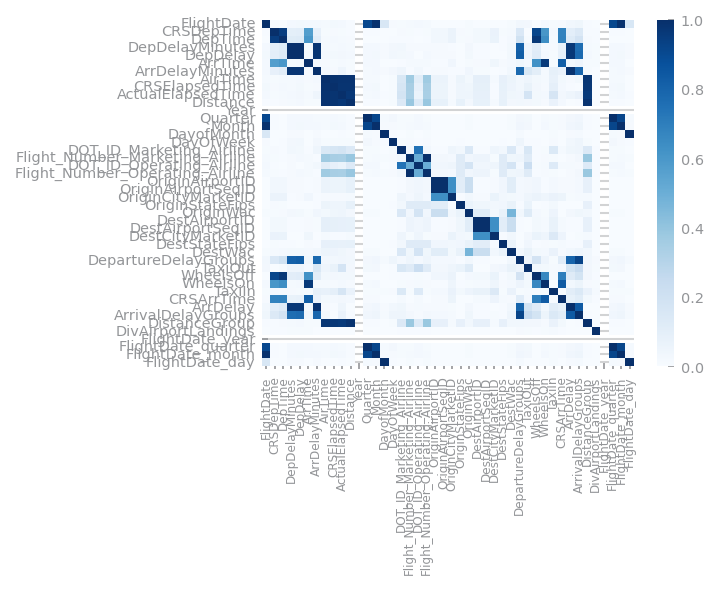

In [18]:
variables_types: dict[str, list] = get_variable_types(data)
numeric: list[str] = variables_types["numeric"]
corr_mtx: DataFrame = data[numeric].corr().abs()

figure()
heatmap(
    abs(corr_mtx),
    xticklabels=numeric,
    yticklabels=numeric,
    annot=False,
    cmap="Blues",
    vmin=0,
    vmax=1,
)
savefig(f"../charts/lab2_profiling/{file_tag}_correlation_analysis.png", bbox_inches='tight')
show()